# 프로젝트: 뉴스기사 요약해보기

뉴스 기사 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보자.



## 1. 추상적 요약(Abstractive Summarization)

- 원문으로부터 내용이 요약된 **새로운 문장을 생성**해 내는 것
- **새로운 문장**이라는 것은 결과로 나온 문장이 원문에 원래 없던 문장일 수도 있다는 것을 의미
- 자연어 처리 분야 중 자연어 생성(Natural Language Generation, NLG)의 영역
- 자연어 생성의 가장 기본적인 신경망 중의 하나인 RNN으로 추상적 요약 방식을 구현해 보자.
    - RNN의 단점인 `장기 의존성(long term dependencies)` 문제 보완을 위한
    - LSTM, GRU 도 있지만 구글에서 설계한 **seq2seq(sequence to sequence)** 모델을 사용해보자.
    

### 참고.  낯선 package를 알아보자.
1. [nltk(Natural Language Toolkit)](https://www.nltk.org/index.html)
    - 자연어 처리 위한 python 패키지
    - 영어 텍스트 전처리 작업시 많이 쓰는 라이브러리
    - 50여개가 넘는 말뭉치 리소스를 활용해 영어 텍스트 분석할 수 있게 제공
    - 아나콘다 설치하면 기본으로 설치
    - 아래 커맨드로 별도 설치 가능  
        ```pip install nltk```
    - nltk 기능 제대로 사용위해 `import nltk` 후 아래와 같이 
    - nltk data(NLTK 실습에 필요한 각종 패키지와 말뭉치(corpus, 코퍼스) 추가 설치  
        ```nltk.download()```  
    - [참고 2](https://wikidocs.net/22488)

2. [re](https://velog.io/@devxyoon/%ED%8C%8C%EC%9D%B4%EC%8D%AC%EC%97%90%EC%84%9C-%EC%A0%95%EA%B7%9C-%ED%91%9C%ED%98%84%EC%8B%9D%EC%9D%84-%EC%A7%80%EC%9B%90%ED%95%98%EB%8A%94-re-%EB%AA%A8%EB%93%88)
    - [정규 표현식](http://pythonstudy.xyz/python/article/401-%EC%A0%95%EA%B7%9C-%ED%91%9C%ED%98%84%EC%8B%9D-Regex)을 지원하기 위한 모듈
    - regular expression, 간단히 regex 의 앞글자 따온것
    - python 내장 라이브러리(별도 설치없이 사용)
    - 정규 표현식은 특정한 규칙을 가진 문자열의 패턴을 표현하는 데 사용
    - 자연어 처리 분야에서 전처리 과정에서 많이 사용하며, 특정 문자열을 제거, 검색 혹은 치환 등에 주로 사용
    - [참고 3](https://ko.wikipedia.org/wiki/%EC%A0%95%EA%B7%9C_%ED%91%9C%ED%98%84%EC%8B%9D)
    

3. [urllib.request](https://velog.io/@shchoice/urllib.request-urlretrieve-urlopen)
    - url 주소의 문서를 열고 읽기 위해 사용하는 모듈
    - 본 프로젝트에서는 `urllib.request.urlretrieve` 사용
        - URL로 표시된 네트워크 객체(URL 주소의 문서)를 로컬 파일로 저장, 즉 직접 다운로드 가능
    - [참고 2. docs.python.org](https://docs.python.org/ko/3/howto/urllib2.html)

4. [BeautifulSoup](https://defineall.tistory.com/640)
    - 주로 웹 크롤링(web crawling)에 사용되는 라이브러리
    - HTML정보로 부터 원하는 데이터를 가져오기 쉽게, 비슷한 분류의 데이터별로 나누어주는(parsing) 파이썬 라이브러리
    - 보통 html정보를 가져오는 urllib.request.urlopen() 모듈과 함께 사용
    - `warnings.filterwarnings("ignore", category=UserWarning, module='bs4')`    
        - BeautifulSoup 에서 html 태그가 아닌 디렉토리의 경로와 같은 형태가 들어왔다고 보내주는 `warning`을 없애는 것
        - [참고 2. warnings 해결](https://domdom.tistory.com/172)  
    - [참고 3. wikidocs.net](https://wikidocs.net/85739)
    - [참고 4. beautigul soup 공식문서](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)

### Step 1. 데이터 수집하기

데이터는 아래 링크에 있는 뉴스 기사 데이터`(news_summary_more.csv)`를 사용하자.

- [sunnysai12345/News_Summary](https://github.com/sunnysai12345/News_Summary)


In [1]:
# package load
import nltk
nltk.download('stopwords')  # nltk에서 불용어 사전 다운로드

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


=3


- 아래의 코드로 데이터 다운로드

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [3]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [4]:
#랜덤한 15개 샘플 출력
data.sample(15)

,headlines,text
79768,9/11 survivors urge UK PM May to release Saudi...,Survivors of the 9/11 attacks have written to ...
40351,Having a baby doesn't mean I can't wear short ...,Responding to social media users trolling her ...
81601,Pakistan conducts fifth-most executions in wor...,Pakistan has executed as many as 465 prisoners...
54562,Lisbon has world's oldest surviving doll hospital,"There is a doll hospital in Lisbon, Portugal, ..."
96456,Indian-origin lady convicted over fake clothin...,The Birmingham Crown Court has convicted an In...
58930,Ã¢ÂÂ¹20cr case on cop who said Sasikala got V...,A Ã¢ÂÂ¹20-crore defamation case has been file...
47932,Every ministry has officer on special duty fro...,Addressing businessmen and professionals in Ka...
33851,Indu Malhotra to be first woman lawyer appoint...,Senior advocate Indu Malhotra is set to become...
39995,Army rescues 500 people in Shillong amid commu...,The Army has rescued 500 people from disturbed...
79310,Philippines extends martial law on island besi...,Philippine lawmakers have voted 261-18 to reta...


- 뉴스 기사의 헤드라인과 본문에 해당되는 headlines 과 text 두 가지 열로 구성

- 인공 신경망을 통해 text 시퀀스를 입력받으면, headlines 시퀀스를 예측하도록 인공 신경망을 훈련 하자.
___

### Step 2. 데이터 전처리하기(1)

- 빈칸으로 존재하는 null 데이터
- 의미는 같지만 다른 식으로 작성된 글 같은 중복 항목
- 학습할 때 방해가 되는 데이터를 먼저 솎아내자

- 중복 샘플 유무 확인과 NULL 값이 존재하는 샘플 제거

In [5]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


- 중복 제외시 아래와 같이 유니크한 데이터가 존재
    - headlines : 98,280개
    - text      : 98,360개
- headlines은 함축적으로 기사를 표현하는 간단한 요약들도 많아서 text가 달라도 headlines은 동일할 수 있기에 중복 샘플은 제거
- 데이터프레임의 `drop_duplicates()`를 사용하여 중복 샘플 제거


In [6]:
# inplace=True 설정으로 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꾸자
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


- 이제 데이터에 Null 값이 있는지 확인
    - 데이터프레임에 Null 값이 있는지 `.isnull().sum()`을 사용

In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


- Null 값은 없는 것으로 확인
___

### Step 3. 텍스트 정규화와 불용어 제거

- 98,360개의 샘플
- 단어들 중 같은 의미이지만 다른 표현으로 사용되어 마치 다른 단어들처럼 간주되는 경우 제거
    - `it'll`은 `it will`과 같고, `mustn't`과 `must not`은 같은 표현
    - 이런 단어를 제거하여 연산량을 줄이자
- 이런 텍스트 처리를 **텍스트 정규화(text normalization)** 라고 한다.

- 아래 링크를 참조하여 텍스트 정규화를 위한 사전(dictionary)을 구성했다.

- [정규화 사전 출처](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)


In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


- 정규화 완료
___

- 텍스트에는 자주 등장하지만 실질적으로 도움이 되지 않는 단어들을 불용어(stopwords)라고 부른다.
- 불용어를 제거하여 자연어 처리의 성능을 높여보자.
- NLTK에서 제공하는 불용어 리스트를 활용해 샘플에서 불용어를 제거하자.

In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

- NLTK에서 제공하는 불용어는 총 179개다.
- 이를 사용하여 불용어를 제거하자. 또한
- 모든 영어 문자 👉 소문자
- html 태그 제거
- 정규 표현식으로 각종 특수문자 제거하자.  
<br>

- 아래 함수의 하단의 if문으로 Text 전처리 시에서만 호출하고 문장 길이가 짧은 headlines 전처리할 때는 호출하지 않토록 코딩
- 함축적인 의미의 headlines 결과문이 자연스러운 문장이 되도록 불용어들이 headlines 에는 남아 있는 게 더 좋겠다고 판단

In [10]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


- 전처리 전, 후의 결과를 아래와 같이 임의의 headlines과 text를 만들어 확인해 보자.
- [headlines 참고 링크](https://english.chosun.com/site/data/html_dir/2022/01/29/2022012900622.html)

In [11]:
temp_headlines = 'Toyota heading to moon with cruiser, robotic arms and dreams!!!'
temp_text = "Toyota is working with Japan's space agency (on a vehicle) to explore the lunar surface,<br />with ambitions to help people live on the moon by 2040 and then go live on Mars, company officials said Friday."

print("headlines: ", preprocess_sentence(temp_headlines, False))  # 불용어 제거하지 않는다
print("text:", preprocess_sentence(temp_text))  

headlines:  toyota heading to moon with cruiser robotic arms and dreams
text: toyota working japan space agency explore lunar surface ambitions help people live moon go live mars company officials said friday


- 임의의 데이터로 확인한 결과
    - 모든 알파벳이 소문자로 변환
    - `<br />`과 같은 html 태그가 제거
    - `(on a vehicle)`과 같은 괄호로 묶였던 단어 시퀀스 제거
    - 특수문자 제거


- 함수가 잘 작동하는 것으로 확인되었다.
- 훈련 데이터 전체에 대해서 전처리를 수행
- text의 경우에는 불용어 제거, headlines 의 경우 불용어 미제거 할 것이기에 따로 호출
- text 전처리 후, 결과 확인 해보자.


In [12]:
clean_text = []
# 전체 text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

- headlines 전처리 시 불용어 미제거이기에 두 번째 인자로 False를 넣어주자.

In [13]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


- 텍스트 정제 과정을 거친 후 문장의 모든 단어가 사라지는 경우가 있으므로
- 빈(empty) 값을 가진 샘플들은 Null 값으로 대체하자.

In [14]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


- `.isnull().sum()`을 사용해서 Null 값이 있는지 확인해 보자.

In [15]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [16]:
len(data)

98360

- Null 값도 없고 data 의 변화가 없음을 확인했다.
___


### Step 4. 데이터 전처리하기(2)

- 훈련데이터와 테스트데이터 나누기
    - 학습에 사용할 데이터의 크기 결정
    - 문장의 시작과 끝을 표시해 주자

### 샘플의 최대 길이 정하기
___

- 훈련에 사용할 샘플의 최대 길이 구하기
- text와 headlines 의 최소, 최대, 평균 길이를 구하고 길이 분포를 시각화 해보자.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


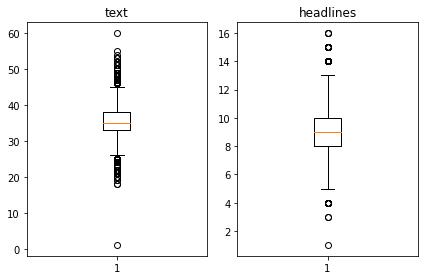

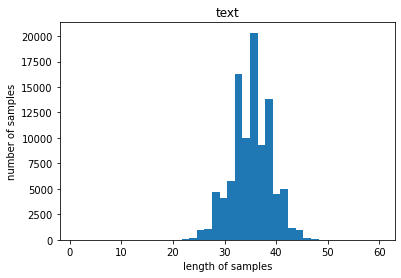

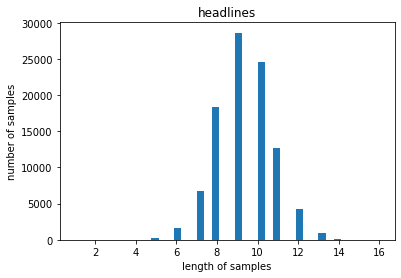

In [17]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 시각화 한 데이터를 확인해 보자.
- text의 경우 최소 길이가 1, 최대 길이가 60으로 차이가 크지만 평균 길이는 35로 확인된다.
- headlines의 경우 최소 길이가 1, 최대 길이가 16, 평균 길이가 9로 상대적으로 text에 비해 짧은 것으로 확인된다.
- 이를 토대로 text와 headlines의 적절한 최대 길이를 정해보자.

In [18]:
text_max_len = 44
headlines_max_len = 12
print('=3')

=3


- 각각 44와 12로 정했다. 
- 이것은 위의 box plot에서 이상치와 경계가 되는 지점의 길이로 선택해 보았다.
- 위에 나온 문장길이에 대한 통계를 보고 중간값이나 제3사분위의 값을 적용해 보았지만
- 만족할 만한 성능을 얻기는 쉽지 않았다.


- 왜 그런지 궁금하여 구글링으로 검색도 해 보았지만 확인할 수 없었고 마지막으로
- 책에는 있지 않을까 하는 생각에 `위키북스`에서 나온 `자연어 처리` 책을 구입하여 찾아보았고 
- 그 책에서도 나와 같은 결과로 인해서 모델 학습 시도를 여러 번 한 끝에 
- `경험적으로 좋은 성능이 나올 수 있는 문장 길이를 설정`했다고 기술되어 있었다.
- 따라서 통계적인 데이터에 의한 문장길이 설정으로는 큰 변동이 없다고 판단하여 
- 아래와 같이 전체 샘플을 거의 포함할 수 있는 문장 길이로 선택하여 변화를 시도해 보았다.

In [19]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [20]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 44 이하인 샘플의 비율: 0.9933712891419276
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


- 각각 44와 12로 패딩을 하게 되면 거의 대부분의 샘플을 포함하게 된다.
- 손실 없이 진행해 보자.


- 아래는 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제하는 코드이다.

In [21]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 96538


### 시작 토큰과 종료 토큰 추가하기
___

- 디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈추는 거였죠.

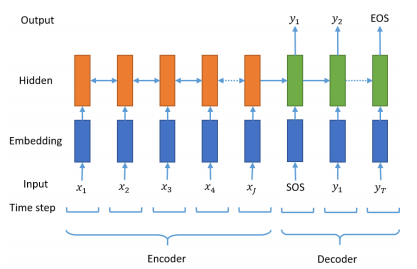
[시작 토큰 SOS와 종료 토큰 EOS는 각각 start of a sequence와 end of a sequence를 나타낸다]

https://arxiv.org/pdf/1812.02303.pdf


- seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있다.
- 시작 토큰은 `sostoken`, 종료 토큰은 `eostoken`이라 임의로 명명하고 앞, 뒤로 추가하자.
- 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 `decoder_input`
- 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 `decoder_target`
- 두 개의 문장 모두 headlines 열로부터 만들자.

In [22]:
# headlines 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


- 앞뒤로 토큰이 잘 붙었다. 인코더의 입력, 디코더의 입력과 레이블(target)을 각각 다시 Numpy 타입으로 저장하자.

In [23]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [24]:
# 섞기 전의 내용 확인
print(encoder_input.shape)
encoder_input[0]

(96538,)


'saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'

- 이제 훈련 데이터와 테스트 데이터를 직접코딩을 통해서 분리해보자.
- 우선, `encoder_input`과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들자.
- 랜덤하게 섞는 과정의 이해를 위해 각각 print() 하여 확인해 보았다.
    - text 데이터인 encorder_input을 np.arange를 사용하여 정수형으로 변환하여 indices에 할당
    - indices를 np.random.shuffle을 사용하여 랜덤하게 섞어주는 과정이다.

In [25]:
indices = np.arange(encoder_input.shape[0])
print(indices)
np.random.shuffle(indices)
print(indices)

[    0     1     2 ... 96535 96536 96537]
[43529 70412 81451 ... 74753 32660 43548]


- 이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 되겠다.

In [27]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [28]:
# 섞은 후의 내용 확인(변경된 것을 확인 할 수 있다.)
encoder_input[0]

'indian pacer mohammad shami wife hasin jahan accused torture multiple extra marital affairs jahan also shared screenshots facebook shami conversations different women besides images alleged girlfriends said cricketer big flirt divorce till last breath soon drag court'

- 이제 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해 주자.

In [29]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19307


- 이렇게 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분하자.

In [30]:
encoder_input_train = encoder_input[:-n_of_val]   # encoder_input에서 테스트 데이터 수 만큼 제외
decoder_input_train = decoder_input[:-n_of_val]   # decoder_input에서 테스트 데이터 수 만큼 제외
decoder_target_train = decoder_target[:-n_of_val]  # decoder_target에서 테스트 데이터 수 만큼 제외

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77231
훈련 레이블의 개수 : 77231
테스트 데이터의 개수 : 19307
테스트 레이블의 개수 : 19307


- 훈련 데이터와 테스트 데이터가 각각 77,231개와 19,307개로 잘 분리되었다.

### Step 5. 데이터 전처리하기(3)

### 단어 집합(vocabulary) 만들기 및 정수 인코딩

- 이제 텍스트를 숫자로 처리할 수 있도록 훈련, 테스트 데이터의 단어들을 모두 정수로 바꿔주자.
- 이 과정을 **단어 집합(vocabulary)** 을 만든다고 한다.
- 훈련 데이터에 대해서 단어 집합을 만들어보자.
- 우선, 원문에 해당되는 `encoder_input_train`에 대해서 단어 집합을 만들자.

Keras의 토크나이저를 사용하여 입력된 훈련 데이터로부터 단어 집합을 만들 수 있다.

In [31]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


- 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었다.
- 현재 생성된 단어 집합은 `src_tokenizer.word_index`에 저장되어 있다.
- 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행한다.
  
  
- 등장 빈도수가 6회 미만인 단어들이 얼만큼의 비중을 차지하는지 확인해보자.
- `src_tokenizer.word_counts.items()`에는 단어와 각 단어의 등장 빈도수가 저장돼 있기에 통계적인 정보를 얻을 수 있다.

In [32]:
threshold = 6
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68981
등장 빈도가 5번 이하인 희귀 단어의 수: 45161
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 23820
단어 집합에서 희귀 단어의 비율: 65.46875226511648
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.1215814682316765


- `encoder_input_train`에는 6만9천여 개의 단어가 있고 통계 정보들을 해석해보자.
    - 등장 빈도가 5회 이하인 단어 : 약 65% 
    - 실제 훈련 데이터에서 등장 빈도로 차지하는 비중 : 약 3%
    - 등장 빈도가 5회 이하인 단어 : 정수 인코딩과 훈련 데이터에서 제거
    - 이를 제외한 단어 집합의 크기 : 약 23000개로 나왔지만 대략 단어 집합의 크기를 20,000으로 제한
    - 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있다.

In [33]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


- `texts_to_sequences()`는 생성된 단어 집합에 기반하여 
- 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수 인코딩을 수행
- 현재 단어 집합의 크기를 20,000으로 제한했으므로 20,000이 넘는 숫자들은
- 정수 인코딩 후에는 데이터에 존재하지 않는다.



In [34]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[11, 896, 1653, 2422, 165, 7592, 3852, 43, 5742, 1188, 2327, 6520, 604, 3852, 6, 212, 7485, 123, 2422, 5249, 473, 52, 2957, 1691, 104, 10367, 1, 323, 578, 19228, 2681, 561, 29, 7151, 850, 8891, 20], [5, 16, 128, 44, 1, 39, 115, 503, 711, 39, 342, 153, 241, 1231, 56, 153, 241, 816, 1729, 406, 73, 87, 517, 153, 241, 11436, 555, 44, 1, 1552, 2319, 773, 8760, 2598, 5], [122, 30, 49, 2169, 575, 3609, 1529, 1219, 13, 781, 823, 4687, 9551, 74, 1009, 624, 2169, 111, 1, 2480, 1219, 1661, 3781, 147, 19229, 3138, 1009, 624, 42, 7152, 7919, 1219]]


- 텍스트 데이터가 아니라 정수가 확인되고 있다.

- headlines 데이터에 대해서도 동일한 작업을 수행하자. 
- 케라스의 토크나이저를 사용하여 `decoder_input_train`을 입력으로 
- 전체 단어 집합과 각 단어에 대한 빈도수를 계산한다.

In [35]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


- 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었다.
- `tar_tokenizer.word_counts.items()`에는 단어와 각 단어의 등장 빈도수가 저장돼 있다.
- 등장 빈도수가 5회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해보자.

In [36]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29881
등장 빈도가 4번 이하인 희귀 단어의 수: 18378
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11503
단어 집합에서 희귀 단어의 비율: 61.5039657307319
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.9902747079254812


- 등장 빈도가 4회 이하인 단어 : 약 62%
- 실제 훈련 데이터에서 등장 빈도로 차지하는 비중 : 약 4%
- 위에서 했던 것과 동일하게 이 단어들은 모두 제거하고 대략 단어집합의 크기를 10,000으로 제한

In [37]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1382, 115, 824, 123, 6, 2461, 5861, 3640, 879], [1, 14, 83, 324, 689, 9, 1312, 959, 599, 9, 117], [1, 4352, 3, 1223, 272, 2350, 7, 2309, 1115, 34], [1, 137, 104, 24, 205, 4624, 289, 7, 7149, 3745, 96], [1, 2056, 17, 2541, 350, 4353, 7, 148]]
target
decoder  [[1382, 115, 824, 123, 6, 2461, 5861, 3640, 879, 2], [14, 83, 324, 689, 9, 1312, 959, 599, 9, 117, 2], [4352, 3, 1223, 272, 2350, 7, 2309, 1115, 34, 2], [137, 104, 24, 205, 4624, 289, 7, 7149, 3745, 96, 2], [2056, 17, 2541, 350, 4353, 7, 148, 2]]


- 정상적으로 정수 인코딩 작업이 끝났다.
- 현재 `decoder_input_train`과 `decoder_target_train`에는 
- 더 이상 숫자 10,000이 넘는 숫자들은 존재하지 않는다.


- 패딩하기 전에 다음을 확인해 보자.
- 빈도수가 낮은 단어만으로 구성되었던 샘플들은 빈(empty) 샘플이 되었을 수 있다.
- 평균 길이가 9밖에 되지 않았던 headlines 은 이 현상이 있을 수 있다.
- headlines 에서 길이가 0이 된 샘플들의 인덱스를 받아보자.


- 여기서 주의할 점은 `decoder_input`에는 `sostoken` 또는 `decoder_target`에는 
- `eostoken`이 추가된 상태라서, 길이가 0이 된 headlines 의 실제 길이는 1로 나올 것이다.


In [38]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 77231
훈련 레이블의 개수 : 77231
테스트 데이터의 개수 : 19307
테스트 레이블의 개수 : 19307


- 다행히 훈련 데이터에서 제거된 샘플은 없는 것으로 확인되었다.

### 패딩하기

- 텍스트 시퀀스를 정수 시퀀스로 변환했다면, 서로 다른 길이의 샘플들을 같은 길이로 맞춰주는 패딩 작업을 하자.
- 위에서 정해두었던 최대 길이로 `post` 패딩 해 주자.

In [39]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


- 이제 학습에 필요한 데이터 전처리가 모두 끝났다.



### Step 6. 모델 설계하기

- 모델 설계를 함수형 API를 이용해서 인코더를 설계해 보자.


In [40]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

- 임베딩 벡터의 차원은 128로 정의
- hidden state의 크기를 256으로 정의
- hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터.
- 이 파라미터는 LSTM의 용량의 크기나 뉴런의 개수라고 이해하자.


- 인코더의 LSTM은 총 3개의 층으로 구성
- 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내주자.


- LSTM은 dropout 뿐 아니라 recurrent dropout까지 사용.
- 일반적인 dropout은 레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결해주는 방법.
- recurrent dropout은 dropout을 레이어가 아닌 time step마다 해주는 방식.
- time step의 입력을 랜덤으로 생략해 주는 것
- recurrent dropout은 일반적인 dropout와 같이 regularization을 해주는 효과가 있고, 과적합을 방지할 수 있다.


- 아래 그림은 일반적인 dropout과, dropout + recurrent dropout을 동시에 사용한 것을 시각적으로 표현한 것.
- 현재 사용한 LSTM은 dropout과 recurrent dropout을 모두 사용했으니 오른쪽 그림과 같은 형태.
- dropout과 recurrent dropout을 모두 사용한 것을 Variational Dropout이라고도 한다.

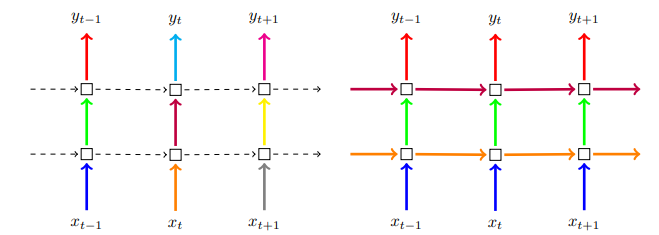
[dropout(왼쪽)과 dropout + recurrent dropout(오른쪽)]

https://arxiv.org/pdf/1512.05287.pdf


>
>참고로 recurrent dropout을 사용하면 아래와 같은 경고문이 뜹니다. 참고하세요~~
>```
WARNING:tensorflow:Layer lstm_15 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU?


- recurrent dropout을 사용할 시 cuDNN을 사용할 수 없어서 학습 시간이 오래 걸립니다.

- recurrent dropout에 대한 자세한 내용은 아래의 논문을 참고하세요.

    - [Recurrent Dropout without Memory Loss](https://arxiv.org/pdf/1603.05118v2.pdf)

<br>

- 이제 디코더를 설계해보자!

In [41]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

- 디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일하다.
- 다른점은 LSTM의 입력을 정의할 때, `initial_state`의 인자값으로 
- 인코더의 `hidden state`와 `cell state`의 값을 넣어줘야 한다는 것


In [42]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 44)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 44, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 44, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

- 디코더의 출력층에서는 `tar_vocab`에서 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 한다.
- 그렇기에 Dense의 인자로 `tar_vocab`을 주고, 활성화 함수로 소프트맥스 함수를 사용하고 있다.


- 지금까지의 설계는 인코더의 hidden state와 cell state를 
- 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq이다.
- 그런데 디코더의 출력층 설계를 바꿔서 성능을 높일 수 있는 방법이 바로 **어텐션 메커니즘**이다.

### 어텐션 메커니즘

- TensorFlow에 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 배워보자.
- 여기서 사용하는 어텐션 함수는 Bahdanau 스타일의 어텐션이다.
- 이 어텐션에 대한 자세한 설명은 [텐서플로우 홈페이지](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AdditiveAttention)와
- 여기를 [Bahdanau 어텐션](https://wikidocs.net/73161), [유투브 영상](https://www.youtube.com/watch?v=WsQLdu2JMgI) 참고하세요.

- 아래와 같이 어텐션 층을 만들고, 위에서 설계한 디코더의 출력층을 수정해 보자.

In [43]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 44)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 44, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 44, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

- 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용
- 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동

### Step 7. 모델 훈련하기

- 설계한 모델을 가지고 훈련을 진행해보자.
- 여기서 `batch_size = 1024`를 사용한 이유가 있다.
- 기존 batch_size = 256
- 이때 시간이 1 epochs : 약 190초, 최종 33 epochs : 약 100분 이상 소요
- 최종 val_loss 결과 : 3.6 으로 나쁘지 않게 나왔지만 시간이 너무 소요가 되었다.
- 그래서 터미널 창에서 `nvidia-smi` 명령으로 메모리 사용량 확인 : 약 4.6GB 사용 중
- 최종 val_loss 결과에 큰 차이만 없다면 batch_size = 1024 로 증가하여 시간 소요 절감시도
- 변경 후 최종 val_loss : 3.7, 최종 소요 시간 : 약 43분. 절반이상 소요시간 절감 
- **아래 참고. 변경 후 학습 내용 스샷**  

    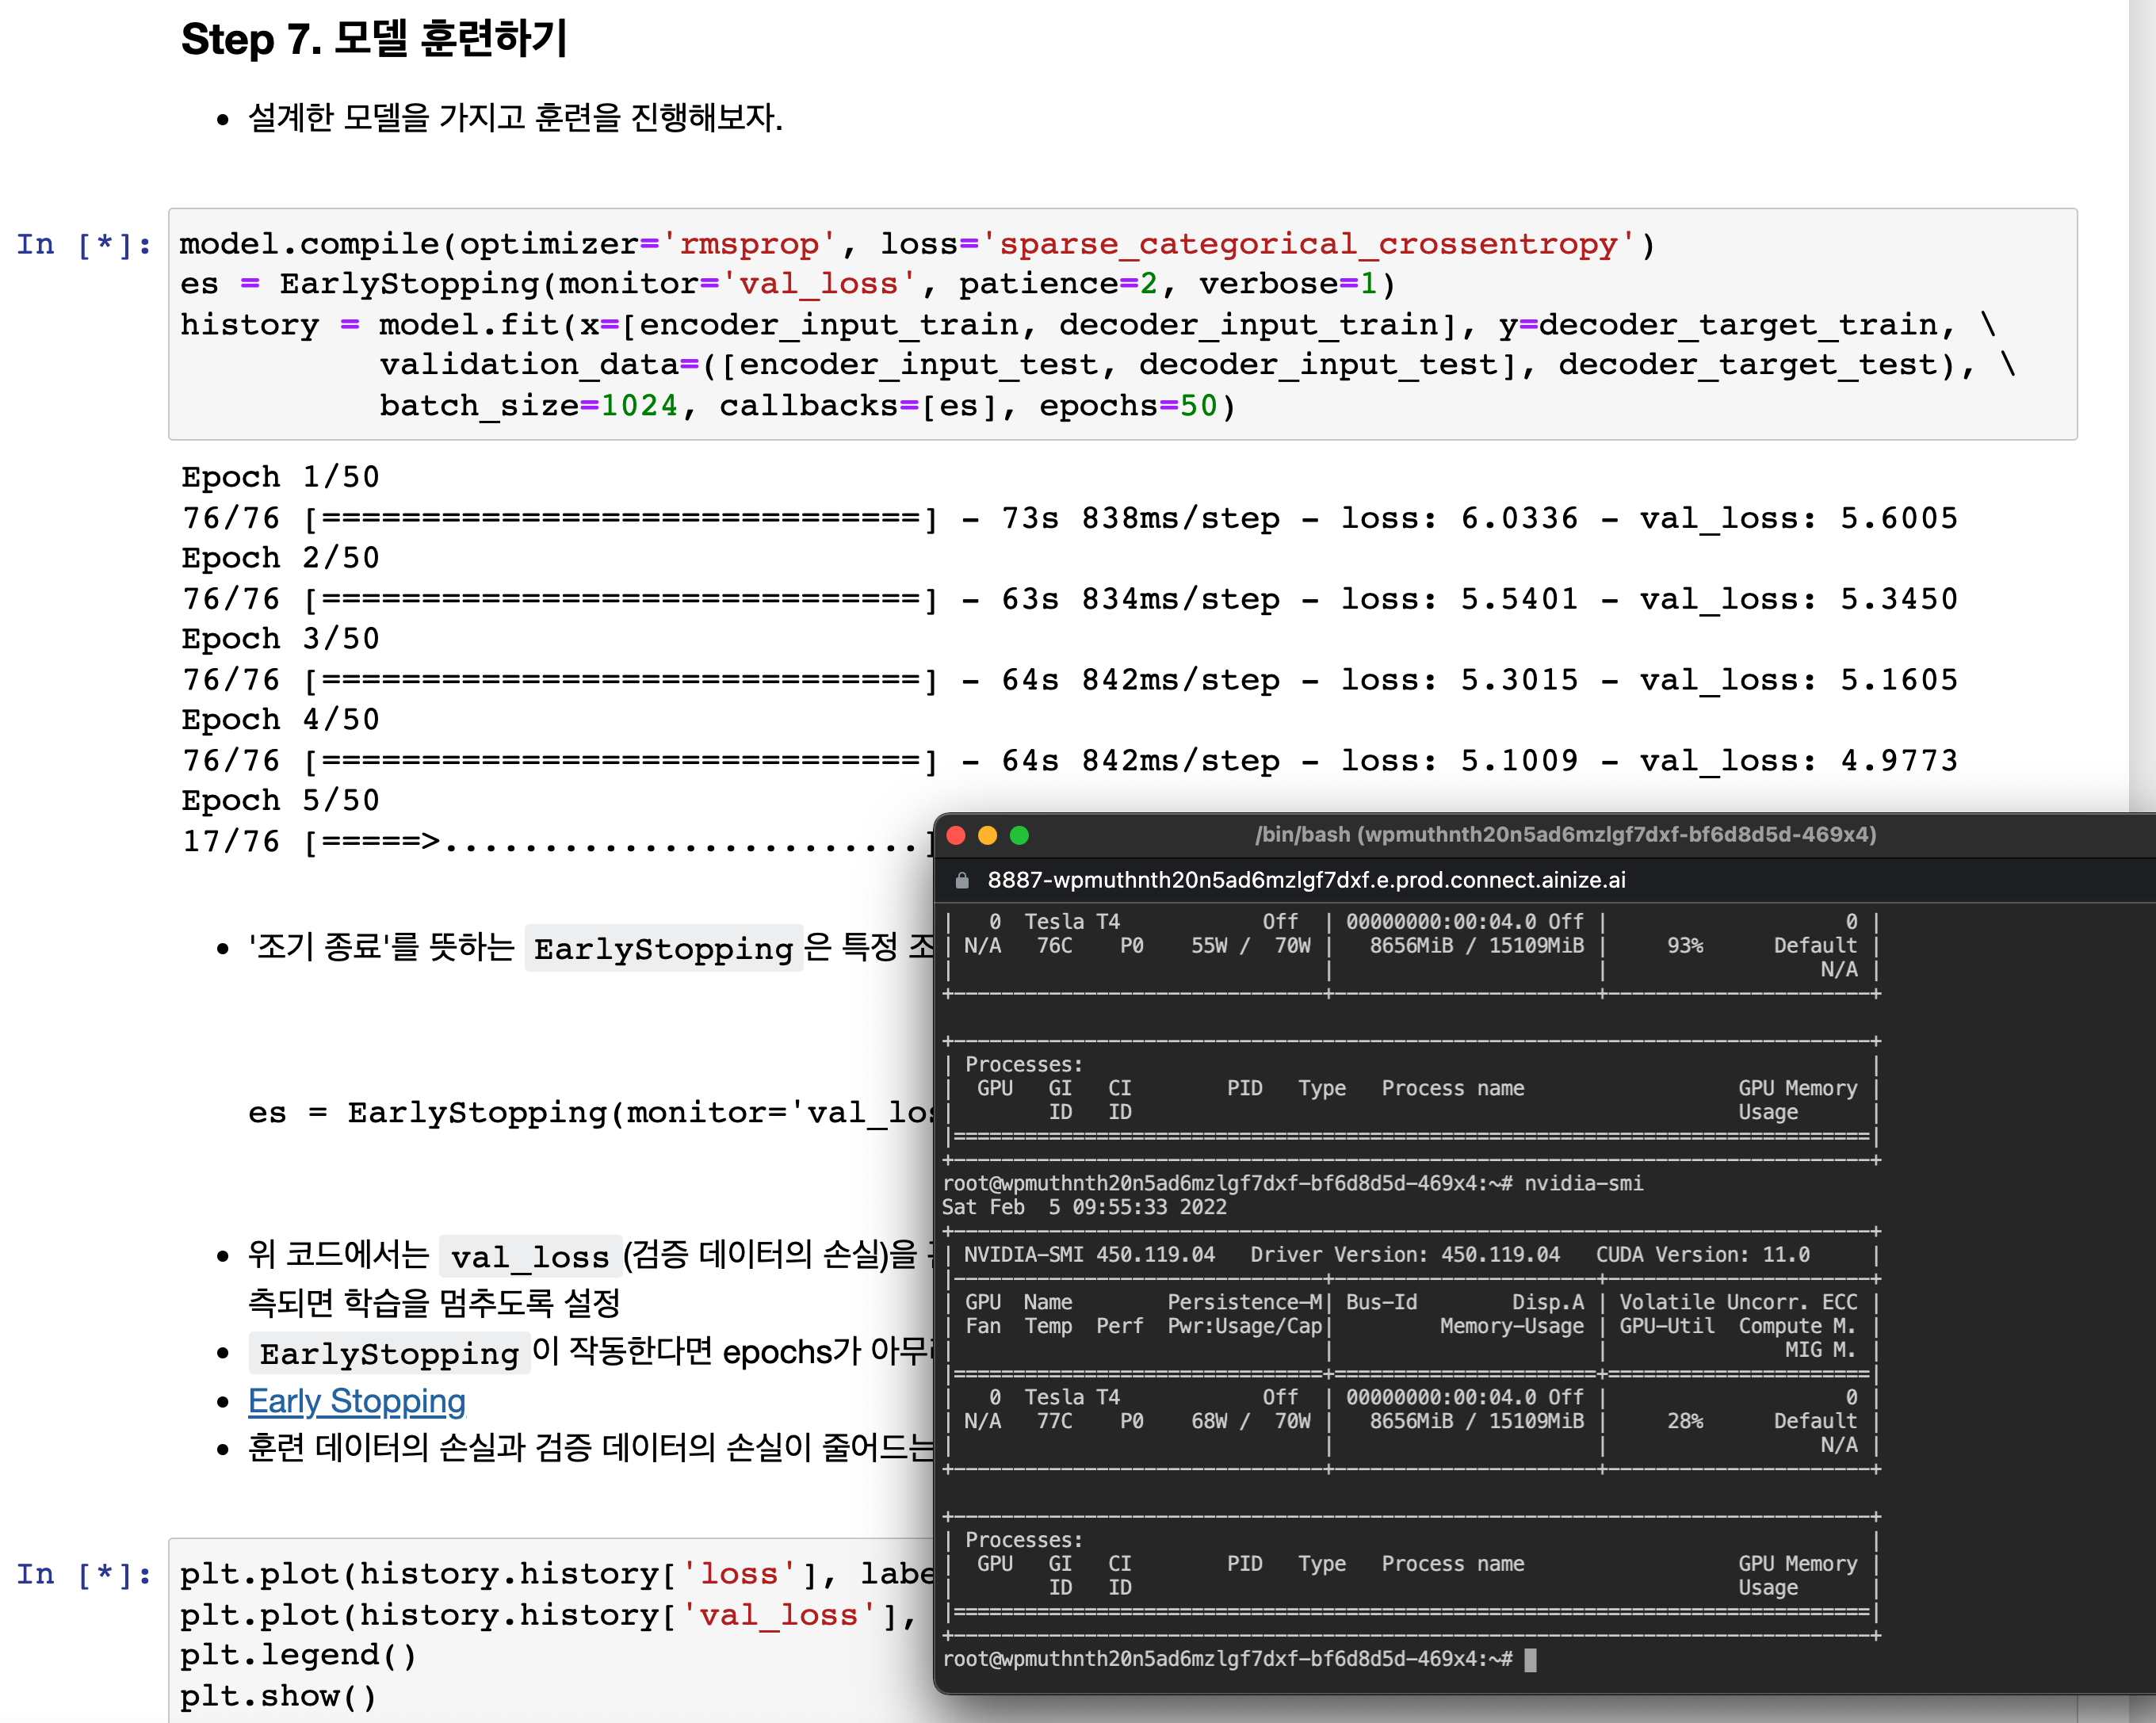



In [44]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=1024, callbacks=[es], epochs=50)

Epoch 1/50
76/76 [==============================] - 73s 838ms/step - loss: 6.0336 - val_loss: 5.6005
Epoch 2/50
76/76 [==============================] - 63s 834ms/step - loss: 5.5401 - val_loss: 5.3450
Epoch 3/50
76/76 [==============================] - 64s 842ms/step - loss: 5.3015 - val_loss: 5.1605
Epoch 4/50
76/76 [==============================] - 64s 842ms/step - loss: 5.1009 - val_loss: 4.9773
Epoch 5/50
76/76 [==============================] - 64s 843ms/step - loss: 4.9215 - val_loss: 4.8476
Epoch 6/50
76/76 [==============================] - 64s 843ms/step - loss: 4.7342 - val_loss: 4.6838
Epoch 7/50
76/76 [==============================] - 64s 843ms/step - loss: 4.5583 - val_loss: 4.5252
Epoch 8/50
76/76 [==============================] - 64s 839ms/step - loss: 4.4112 - val_loss: 4.4195
Epoch 9/50
76/76 [==============================] - 64s 844ms/step - loss: 4.2838 - val_loss: 4.3402
Epoch 10/50
76/76 [==============================] - 64s 841ms/step - loss: 4.1657 - val_lo

- '조기 종료'를 뜻하는 `EarlyStopping`은 특정 조건이 충족되면 훈련을 멈추는 역할.

>`es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)`

- `val_loss`(검증 데이터의 손실)을 관찰하다가, 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정
- `EarlyStopping`이 작동한다면 epochs 가 크게 설정되어도 모델 훈련을 최적점에서 조기 종료 가능

- [Early Stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)
- [Early Stopping 참고 블로그](https://sevillabk.github.io/1-early-stopping/)


- 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정 시각화

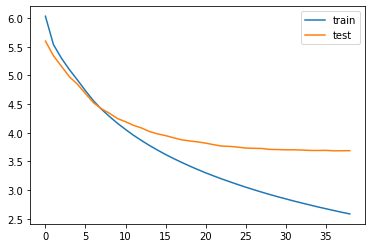

In [45]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Step 8. 인퍼런스 모델 구현하기

- 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원
- 필요한 3개의 사전을 아래와 같이 미리 준비해 두자.

In [46]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


- seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르다.
- 그에 맞게 모델 설계를 별개로 진행해야 한다

- 훈련 단계에서는 인코더와 디코더를 엮은 통짜 모델 하나만 준비했다.

- 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 
- 인퍼런스를 위한 모델 설계를 별도로 해주어야 한다.
- 이때는 인코더 모델과 디코더 모델을 분리해서 설계한다.


In [47]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


- 어텐션 메커니즘을 사용하는 출력층을 설계해 보자.

In [48]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


- 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들자.

In [49]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


### Step 9. 모델 테스트하기

- 테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하다.
- 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어보자.
- 함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 
- headlines의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들자.

In [50]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


- 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교해보자.

In [51]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : china installed high definition cameras along iconic great wall due growing incidents vandalism including foreigners scratch names historic landmark cameras allow real time monitoring provide record events evidence police fine ban offenders visiting site reports said 
실제 요약 : china installs high definition cameras along great wall 
예측 요약 :  china to build chinese soldiers to combat surveillance


원문 : three four nominations received far august vice presidential election rejected wednesday filing began tuesday election commission issuing notification poll two nominees hailing uttar pradesh one andhra pradesh rejected requisite documents 
실제 요약 : out of vice prez nominations received so far rejected 
예측 요약 :  ls polls to be introduced by polls


원문 : saudi arabia crown prince mohammed bin salman wants war yemen leaked emails revealed crown prince statement part conversation us officials details revealed emails saudi led coalition involved yemen civil war since backing yemeni governm

예측 요약 :  cop held for throwing morphed of female constable in up


원문 : actress sunny leone unveiled wax statue madame tussauds new delhi sunny said happy completely awe statue amazing feeling glad chosen incredible honour statue reportedly first wax figure india gives brand 
실제 요약 : sunny leone unveils her wax statue at delhi madame tussauds 
예측 요약 :  sunny leone wax statue unveiled at madame tussauds


원문 : jamaat ud dawah chief mumbai terror attack mastermind hafiz saeed begun campaigning political party milli muslim league ahead general elections pakistan adding mml wants country economically strong saeed said follow muhammad ali jinnah vision notably mml yet registered election commission pakistan 
실제 요약 : mastermind kicks off his party poll campaign in pak 
예측 요약 :  hafiz saeed party chief threatens to contest polls


원문 : south african captain faf du plessis called teammate jp specialist coin first clash zimbabwe buffalo park east london tuesday stand captain odi series du pless

예측 요약 :  kohli has been absolutely absolutely than kohli gavaskar


원문 : uttar pradesh minister op rajbhar repaired metre long road outside residence ahead son wedding reception authorities ignored pleas rajbhar said requested government mend road two months ago avail added option repair ahead function sunday 
실제 요약 : minister road for son wedding as govt ignores plea 
예측 요약 :  up cm announces daughter for daughter to hospital


원문 : windies fast bowler took five wickets within balls five spell bangladesh first test wednesday year old ended figures helping team bowl bangladesh runs overs first innings run total lowest bangladesh test cricket history 
실제 요약 : wi pacer takes wickets in balls to dismiss desh for 
예측 요약 :  bowler takes wickets in balls to take wickets in balls


원문 : indian commerce giant flipkart infused crore online fashion retailer myntra jabong private limited fund infusion reportedly done february via flipkart singapore based subsidiary myntra holding private limited 

- 많은 결과 가운데 대부분은 기존의 headlines 과는 다른 headlines 을 출력하는 것으로 보인다.
- 일부 요약의 경우에는 원문에 없던 단어를 사용해서 전혀 다른 내용의 headlines을 보여준다.
- 대부분이 원문과는 상당히 다른 headlines 이 나와서 의외였다.
- val_loss도 잘 나오고 그래프로 확인해 보아도 흔들림 없이 잘 학습된 것으로 보였는데
- 실제 내용을 확인해 보니 전혀 다른 내용이 대부분이어서 의아한 생각이 들었다.
- 다만 핵심단어들은 어느 정도 포함되어 예측된 결과로 나왔다.

>**실제 요약**  
    - china installs high definition cameras along great wall   
    - 중국, 만리장성 따라 고화질 카메라 설치  
>**예측 요약**  
    - china to build chinese soldiers to combat surveillance  
    - 중국, 감시에 맞서기 위해 중국군을 양성하다
    
>**실제 요약**  
    - saudi crown prince wants out of yemen war reports   
    - 사우디 왕세자, 예멘에서 전쟁 보고 싶어  
>**예측 요약**  
    - saudi crown prince apologises for saudi arabia over  
    - 사우디 왕세자, 사우디 아라비아에 사과
           
- 성능을 개선하기 위해서는 seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법
- 빔 서치(beam search), 사전 훈련된 워드 임베딩(pre-trained word embedding)
- 또는 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)와 같은
- 여러 방안들을 시도해보는게 좋겠다고 생각했다.


## 2. 추출적 요약(Extractive Summarization)

- 원문에서 **문장들을 추출**해서 요약하는 방식
- 예) 10개의 문장으로 구성된 텍스트가 있다면, 그중 핵심적인 문장 3개를 꺼내와서 3개의 문장으로 구성된 요약문을 만드는 식
- 단점 : 결과로 나온 문장들 간의 호응이 자연스럽지 않을 수 있다는 것
- 전통적인 머신 러닝 방식에 속하는 `텍스트 랭크(TextRank)`와 같은 알고리즘을 사용해서 이 방법을 사용
- 실사례 : 네이버 뉴스 서비스에 있는 `요약봇` 기능
    - 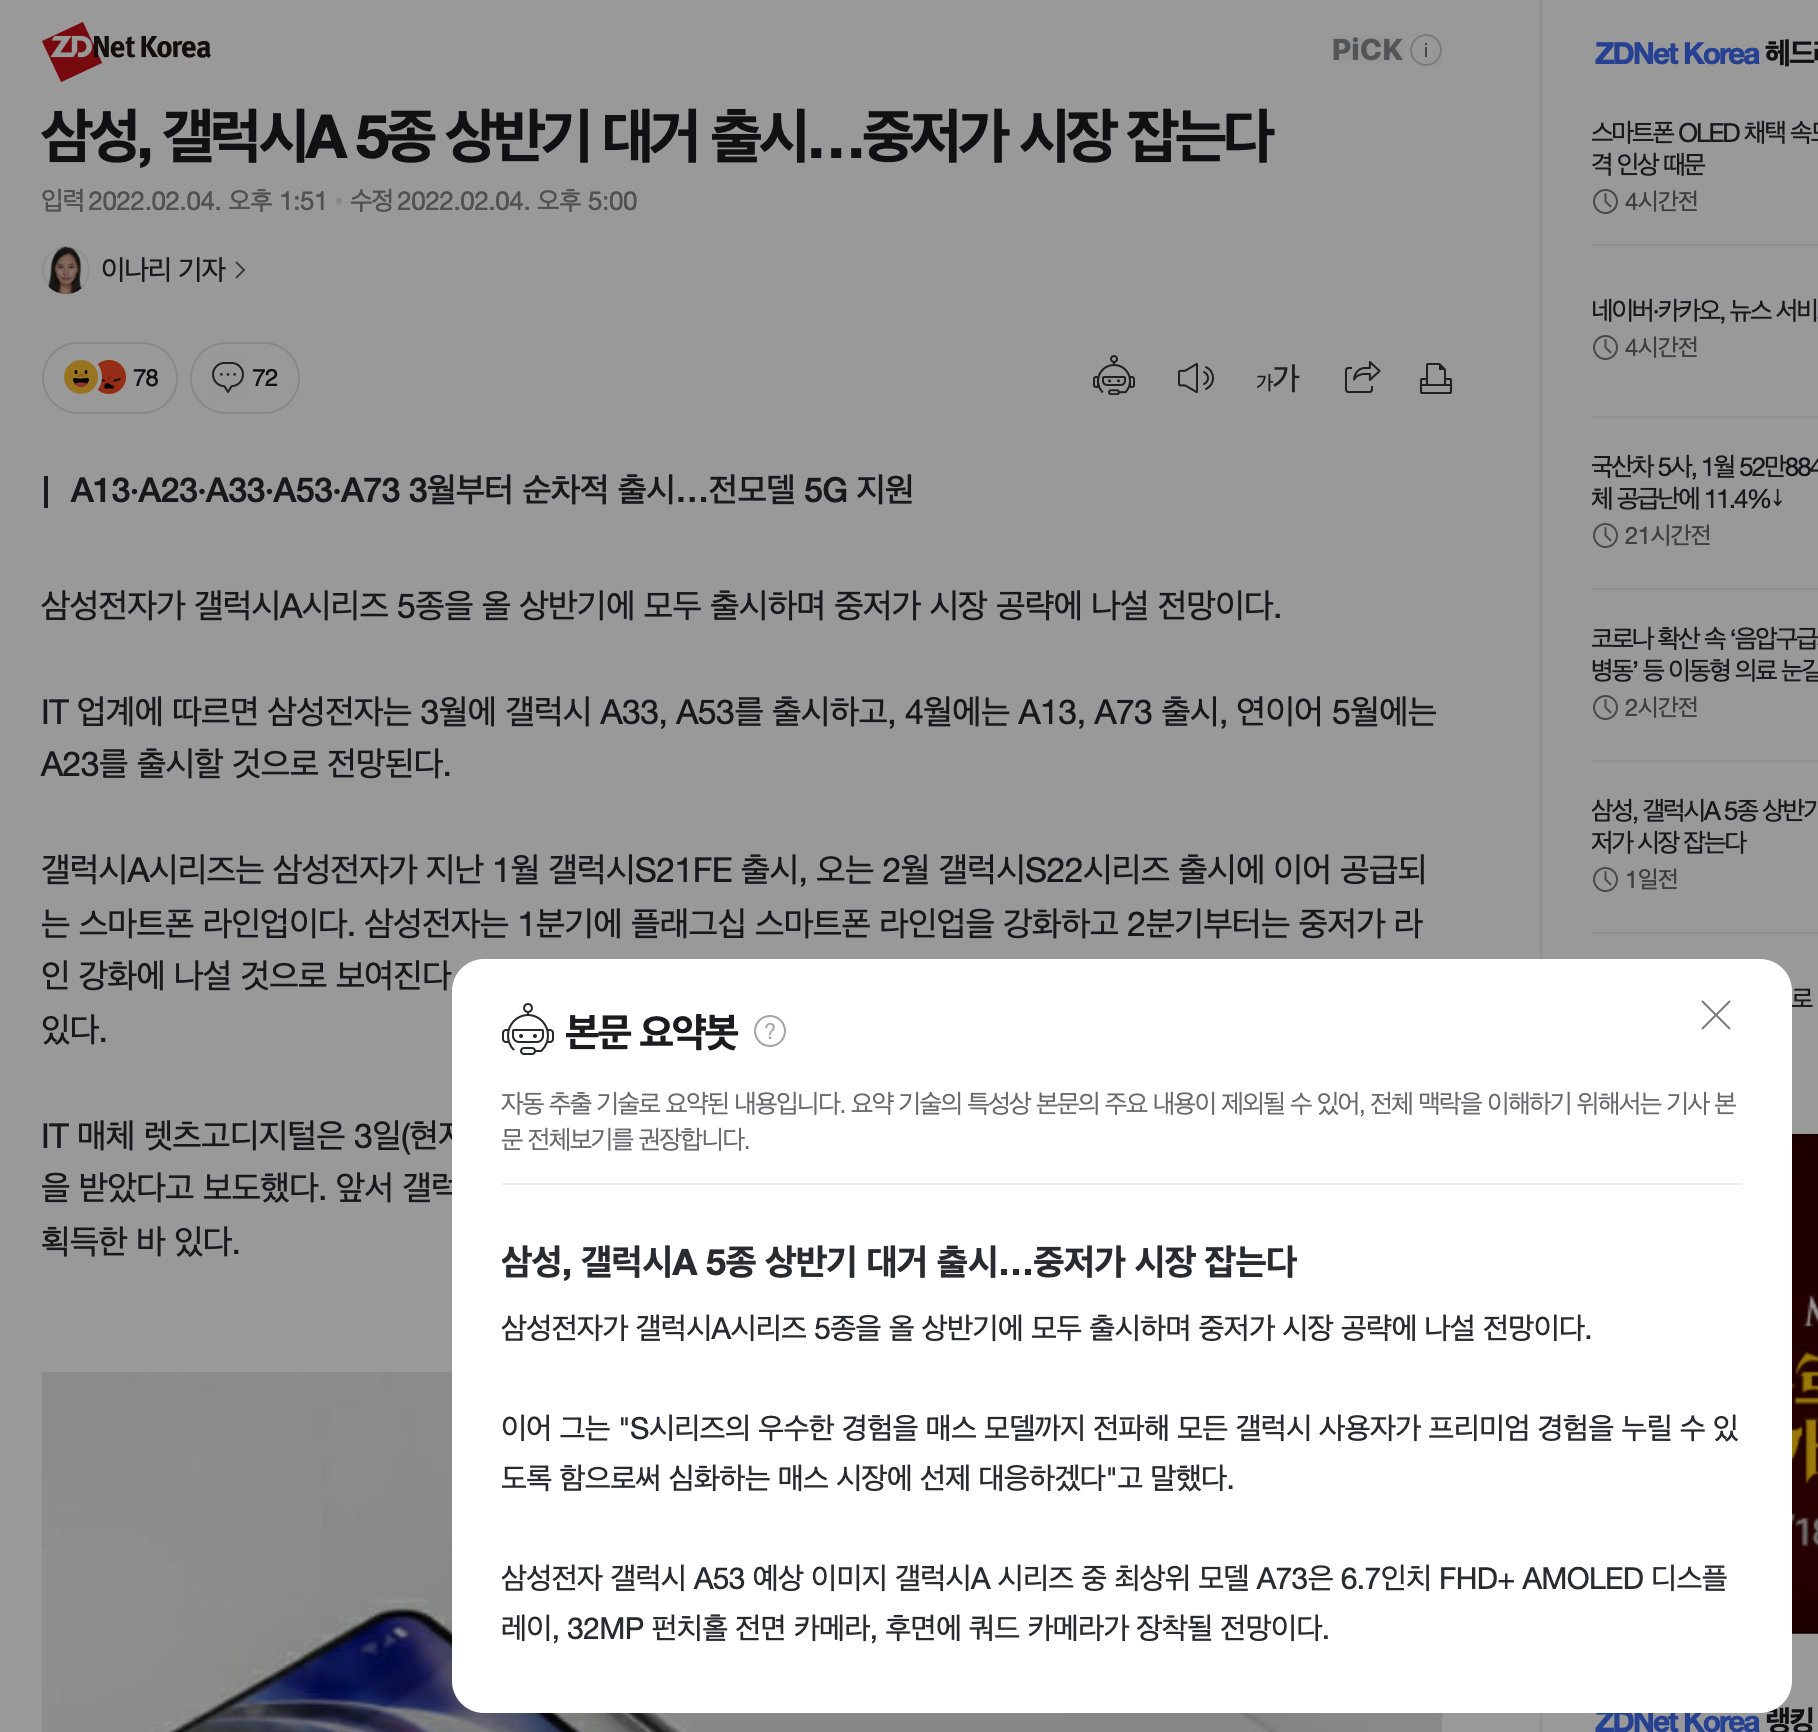
    
- 원문을 구성하는 문장 중 어느 것이 요약문에 들어갈 핵심문장인지를 판별한다는 점에서 문장 분류(Text Classification) 문제로 볼 수 있을 것이다.
- 패키지 `Summa`에서는 추출적 요약을 위한 모듈인 `summarize`를 제공


### 데이터 다운로드하기

In [52]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


이제 text에는 매트릭스 시놉시스가 문자열로 저장돼 있어요. 출력 결과가 아주 길기 때문에 일부만 출력해보고, 잘 저장이 되었는지 확인해볼게요.

In [53]:
print(data[:1500])

                                              headlines  \
0     upGrad learner switches to career in ML & Al w...   
1     Delhi techie wins free food from Swiggy for on...   
2     New Zealand end Rohit Sharma-led India's 12-ma...   
3     Aegon life iTerm insurance plan helps customer...   
4     Have known Hirani for yrs, what if MeToo claim...   
...                                                 ...   
1495  Have seen Sachin Tendulkar get angry but not M...   
1496  Player ensures wife stays dry in rain during A...   
1497  Federer denied entry into locker room by secur...   
1498  42/42 seats in West Bengal: CM Mamata's cutout...   
1499  Court refuses chargesheet by Delhi Police agai...   

                                                   text  
0     Saurav Kant, an alumnus of upGrad and IIIT-B's...  
1     Kunal Shah's credit card bill payment platform...  
2     New Zealand defeated India by 8 wickets in the...  
3     With Aegon Life iTerm Insurance plan, customer...  
4

### summarize 사용하기
___

Summa의 summarize()의 인자로 사용되는 값들에 대해서 알아보자.
>
>- text (str) : 요약할 테스트.
>- ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
>- words (int or None, optional) – 출력에 포함할 단어 수.
    만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
>- split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

- Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행
- 그렇기에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있다.


In [54]:
import requests
from summa.summarizer import summarize

In [55]:
print('Summary:')
print(summarize(data["text"][1], ratio=0.5))
data.head()

Summary:
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


- 리스트로 출력 결과를 받고 싶다면 split 인자의 값을 True로 하자.

In [56]:
print('Summary:')
print(summarize(data["text"][2], ratio=0.5, split=True))

Summary:
['The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.']


- 단어의 수로 요약문의 크기를 조절할 수도 있다. 단어를 50개만 선택해보자.

In [57]:
print('Summary:')
print(summarize(data["text"][3], words=50))

Summary:
With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes.
The plan provides life cover up to the age of 100 years.
Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.


## 회고

- 자연어 처리는 하면 할수록 거리감이 느껴지게 되는 것 같다.
- 데이터 전처리부터 학습하기까지 여러가지 과정을 거쳐서 결과를 도출하지만 
- 시각적으로 확인하는 부분이 어렵다고 해야할 지 부족하다고 해야할 지 
- 기본적인 지식이 부족한 상태에서 자연어 처리하는 과정이 많이 어렵다고 생각된다.
- 학습해야 할 내용도 상당히 많고 짧은 시간에 습득하여 내용을 파악해서 원하는 결과를 얻기에는 
- 너무도 부족한 실력인 것 같다.


- 하이퍼 파라미터를 다양하게 변경해 시도해 보았지만 큰 변화를 얻을 수 없었지만
- 단어 길이와 단어장 크기를 변경했을 때가 유의미한 결과를 얻을 수 있었던 것 같다.
- 이것을 토대로 생각한 것은 최적의 하이퍼 파라미터를 찾는 것도 중요하지만
- 잘 정재된 데이터의 크기도 많은 영향을 미치게 된다는 부분도 확인 할 수 있었던 프로젝트로 생각되고
- 그래서 data augmentation 이 중요하구나!! 하는 생각도 하게 되었다.


- 추상적 요약과 추출적 요약 두가지를 수행해 보았지만 명확한 결과를 도출하는 것은 실패한 것이 아닌가 생각된다.
- RNN 계열의 이해나 RNN의 단점을 보완하기 위해 고안된 LSTM, GRU, seq2seq 에 대해 한발짝은 내딛은 느낌이다.
- 어텐션 메커니즘이나 함수로 처리하는 일련의 코딩은 아직은 이해하기에는 부족하지만 지속적인 노력으로 극복해 보려한다.
- 부족한 부분은 프로젝트 진행하는 곳곳에 참고한 내용의 링크를 달아놓았으니 참고바랍니다.